## Load data and first analysis

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns



In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)


In [3]:
#load the data
df = pd.read_csv('../data/fintech_users.csv')


In [4]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [5]:
print(df.shape)
print(df.dtypes)


(20000, 30)
Customer_ID                     object
Age                              int64
Location                        object
Income_Level                    object
Total_Transactions               int64
Avg_Transaction_Value          float64
Max_Transaction_Value          float64
Min_Transaction_Value          float64
Total_Spent                    float64
Active_Days                      int64
Last_Transaction_Days_Ago        int64
Loyalty_Points_Earned            int64
Referral_Count                   int64
Cashback_Received              float64
App_Usage_Frequency             object
Preferred_Payment_Method        object
Support_Tickets_Raised           int64
Issue_Resolution_Time          float64
Customer_Satisfaction_Score      int64
LTV                            float64
is_churned                       int64
R                                int64
F                                int64
M                              float64
R_rank                           int64
F_rank       

In [6]:
print(df.head())



  Customer_ID  Age  Location Income_Level  Total_Transactions  \
0   cust_6458   16     Urban       Middle                 542   
1  cust_19971   73     Rural          Low                 478   
2  cust_10550   39     Urban         High                 825   
3  cust_20724   72     Rural          Low                 912   
4  cust_20425   30  Suburban          Low                 509   

   Avg_Transaction_Value  Max_Transaction_Value  Min_Transaction_Value  \
0            5907.797586           27410.663071            1153.744409   
1            5212.638655           37871.948484            3875.126934   
2            5198.790494           44712.293146            2408.299267   
3            3252.616689           17553.094170            5491.481250   
4            3275.980136           21674.931340            6727.913038   

    Total_Spent  Active_Days  ...  is_churned    R    F             M R_rank  \
0  3.202026e+06           84  ...           1  252  542  3.202026e+06      1   
1  1

In [7]:
print(df.isnull().sum())


Customer_ID                    0
Age                            0
Location                       0
Income_Level                   0
Total_Transactions             0
Avg_Transaction_Value          0
Max_Transaction_Value          0
Min_Transaction_Value          0
Total_Spent                    0
Active_Days                    0
Last_Transaction_Days_Ago      0
Loyalty_Points_Earned          0
Referral_Count                 0
Cashback_Received              0
App_Usage_Frequency            0
Preferred_Payment_Method       0
Support_Tickets_Raised         0
Issue_Resolution_Time          0
Customer_Satisfaction_Score    0
LTV                            0
is_churned                     0
R                              0
F                              0
M                              0
R_rank                         0
F_rank                         0
M_rank                         0
RFM_Score                      0
Engagement_Score               0
LTV_Class                      0
dtype: int

In [8]:
print("\n--- Object columns ---")
print(df.select_dtypes(include='object').nunique())


--- Object columns ---
Customer_ID                 20000
Location                        3
Income_Level                    3
App_Usage_Frequency             3
Preferred_Payment_Method        4
LTV_Class                       4
dtype: int64


## Numeric value distribution

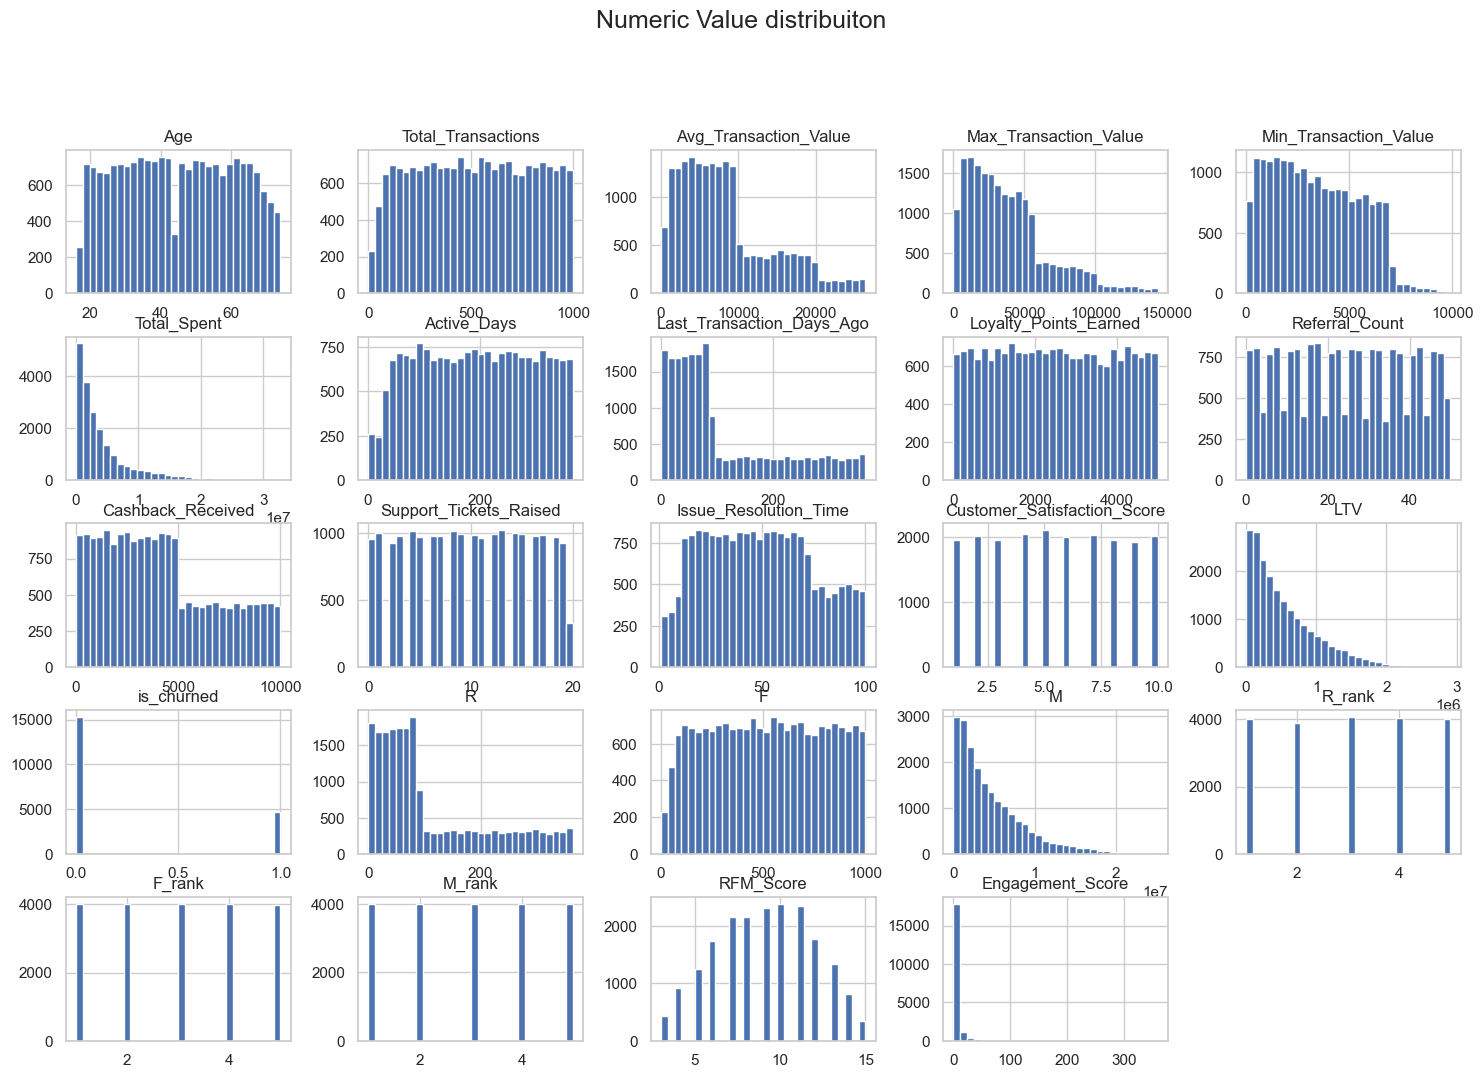

In [11]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Distribution
df[numeric_cols].hist(bins=30, figsize=(18, 14), layout=(6, 5))
plt.suptitle("Numeric Value distribuiton", fontsize=18)
plt.show()

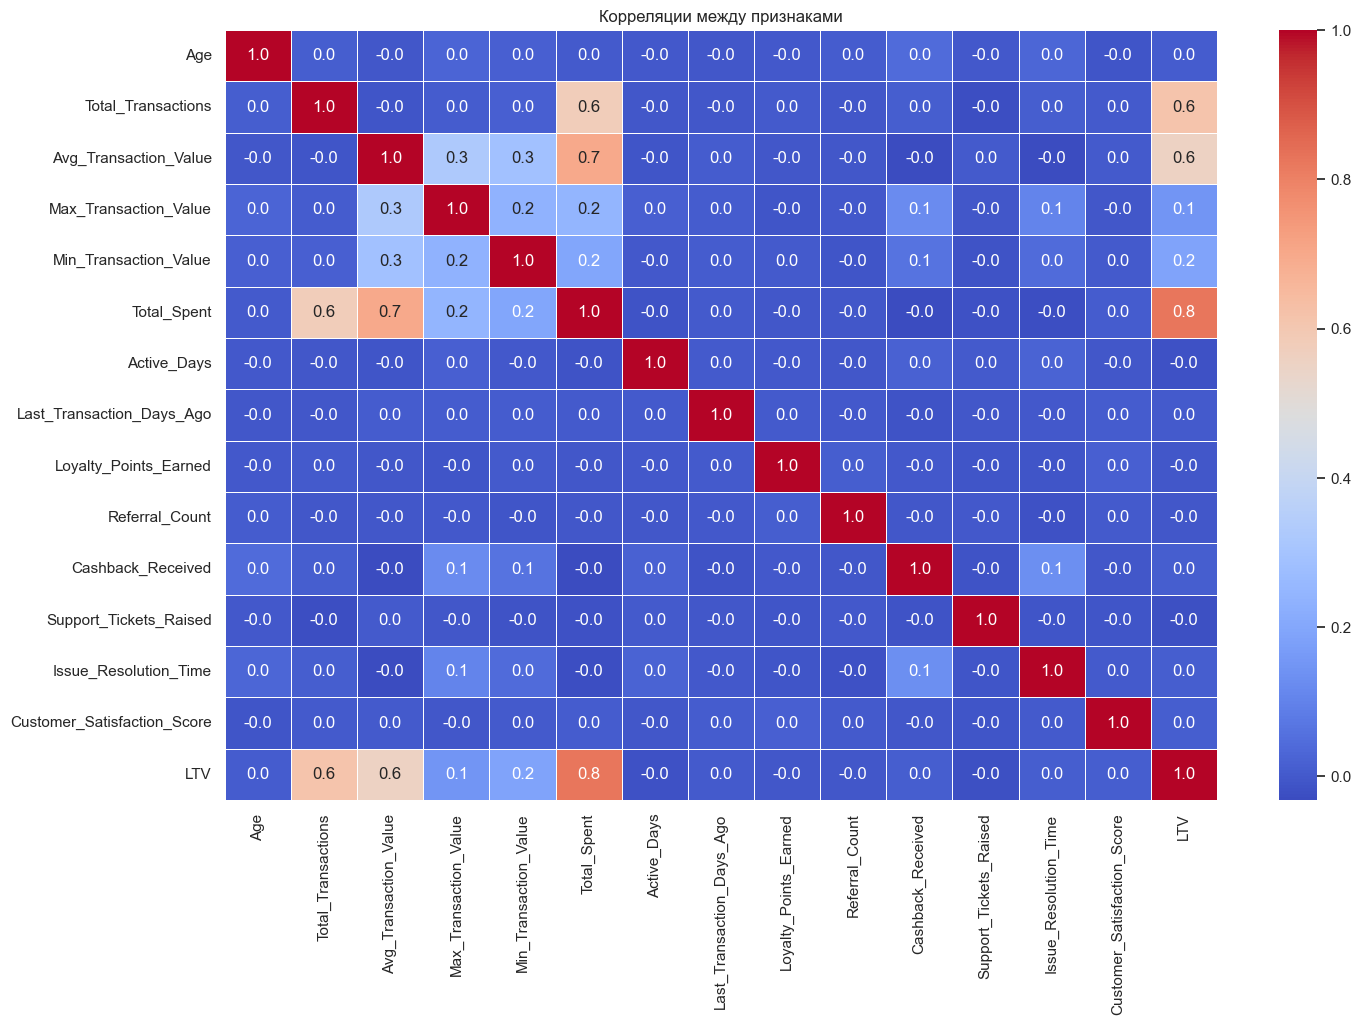

In [ ]:
corr = df[numeric_cols].corr()

plt.figure(figsize=(16, 10))
sns.heatmap(corr, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5)
plt.title("Корреляции между признаками")
plt.show()

### Creating another column is_churned based on time of last 90 day transactions

In [ ]:
# Условие: если не было активности 90 дней и более — считаем, что ушёл
df['is_churned'] = df['Last_Transaction_Days_Ago'].apply(lambda x: 1 if x >= 90 else 0)

# Проверка
print(df['is_churned'].value_counts())

is_churned
0    12847
1     7153
Name: count, dtype: int64


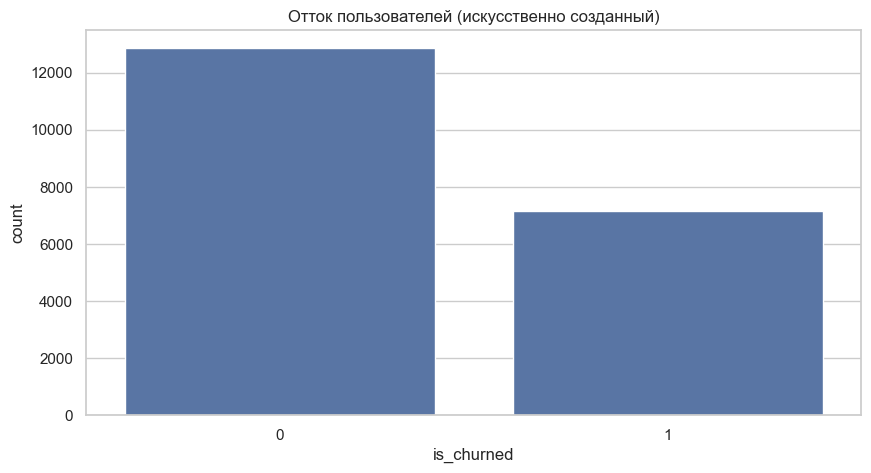

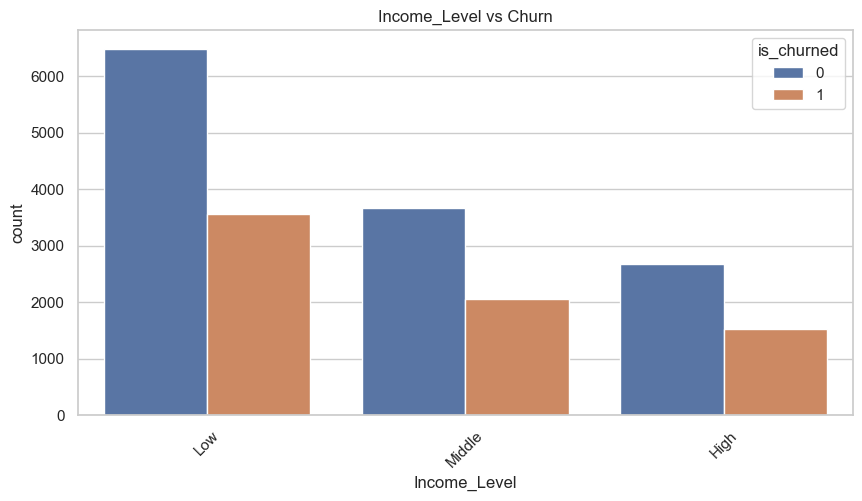

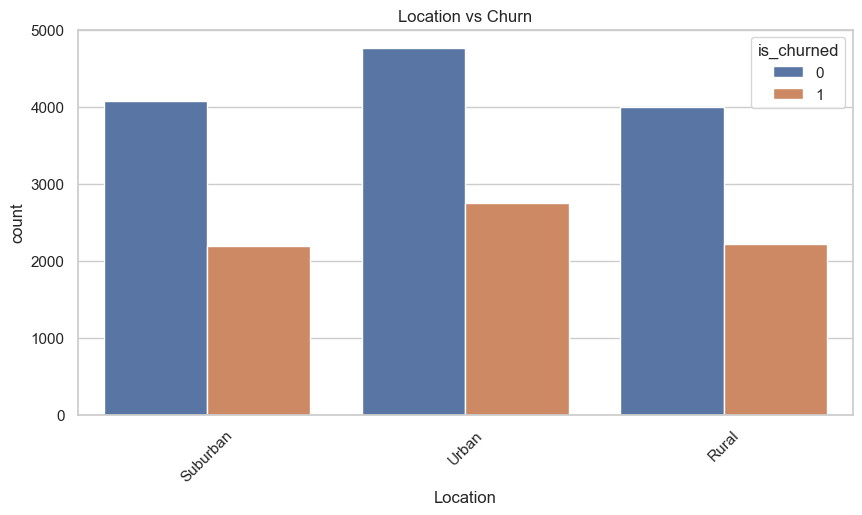

In [ ]:
churn_col = 'is_churned'

sns.countplot(data=df, x=churn_col)
plt.title("Отток пользователей (искусственно созданный)")
plt.show()

for col in ['Income_Level', 'Location']:
    sns.countplot(data=df, x=col, hue=churn_col)
    plt.title(f"{col} vs Churn")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
df['R'] = df['Last_Transaction_Days_Ago']
df['F'] = df['Total_Transactions']
df['M'] = df['Total_Spent']

df['R_rank'] = pd.qcut(df['R'], 5, labels=[5, 4, 3, 2, 1])
df['F_rank'] = pd.qcut(df['F'], 5, labels=[1, 2, 3, 4, 5])
df['M_rank'] = pd.qcut(df['M'], 5, labels=[1, 2, 3, 4, 5])

df['RFM_Score'] = df[['R_rank', 'F_rank', 'M_rank']].sum(axis=1)

df['RFM_Score'].head(100)

0      5
1     10
2      5
3      8
4     11
      ..
95    10
96     8
97    12
98    11
99    11
Name: RFM_Score, Length: 100, dtype: int64

In [ ]:
df['Engagement_Score'] = df['Active_Days'] / (df['Last_Transaction_Days_Ago'] + 1)  # +1 чтобы избежать деления на 0


In [ ]:
df['is_churned'] = (df['Last_Transaction_Days_Ago'] > 180).astype(int)


In [ ]:
df['LTV_Class'] = pd.qcut(df['LTV'], 4, labels=['Low', 'Medium', 'High', 'Very High'])


## LTV Prediction using Random Forest model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

data = pd.read_csv('../data/fintech_users.csv')




In [29]:
features = [
    'Age', 'Total_Transactions', 'Avg_Transaction_Value', 'Total_Spent',
    'Active_Days', 'Last_Transaction_Days_Ago', 'Loyalty_Points_Earned',
    'Referral_Count', 'Cashback_Received', 'Issue_Resolution_Time',
    'Customer_Satisfaction_Score', 'RFM_Score', 'Engagement_Score'
]

X = data[features]
y = data['LTV']


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [31]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)


In [17]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


MAE: 108712.12
RMSE: 175138.20
R²: 0.86


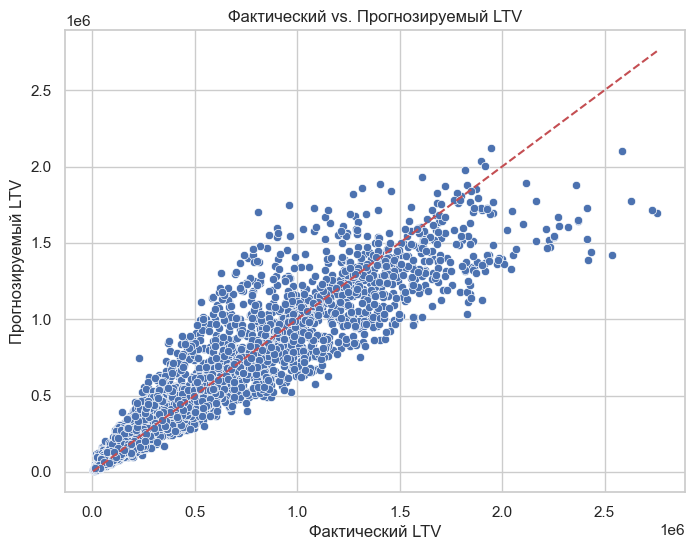

In [ ]:

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Фактический LTV")
plt.ylabel("Прогнозируемый LTV")
plt.title("Фактический vs. Прогнозируемый LTV")
plt.grid(True)
plt.show()

In [ ]:
target = 'LTV'

features = df.select_dtypes(include=[np.number]).drop(columns=['LTV']).columns.tolist()

X = df[features]
y = df[target]

# seperate for train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Prediction
y_pred_lr = lr_model.predict(X_test)

In [20]:
mae = mean_absolute_error(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)

print(f"Linear Regression:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


Linear Regression:
MAE: 207466.40
RMSE: 284491.93
R²: 0.64


### So Linear Regression shows worse results than Random Forest due to complexity of dataset and other features